## Import Libraries

In [1]:
import numpy as np
from random import sample
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import math
import collections

## Import the Reward and Transition Matrix from the xls file

In [2]:
#Import the reward table and the transition matrix
r_table = pd.read_excel('environment_matrices.xlsx', sheet_name ='rewards', index_col=0)
state_value_function = pd.read_excel('environment_matrices.xlsx', sheet_name ='State value function')
transition_matrix = pd.read_excel('environment_matrices.xlsx', sheet_name ='transition',index_col=0)

## Initialize important parameters and Q matrix

In [3]:
#Initialize parameters
total_episodes = 10000 #Total episodes
number_of_steps = 100 #Maximum steps per episode
T = 0.5 #For the Boltzamann's formula

#Q Learning parameters
alpha = 0.2 #Learning rate
gamma = 0.99 #Discount rate

#Initialization of the Q matrix
q_table = pd.DataFrame(np.matrix(np.zeros([16,4])).astype("float32"), columns = transition_matrix.columns, index = transition_matrix.index)
q_table.head()

,UP,DOWN,RIGHT,LEFT
A,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0


In [4]:
#%% Define the optimal state value table
optimal_state_value_function = np.array(state_value_function)
optimal_state_value_function

# plot_values(optimal_state_value_function)

array([[-6, -5, -4, -5],
       [-5,  0, -3,  0],
       [-4, -3, -2,  0],
       [ 0, -2, -1,  0]])

## Boltzmann (softmax) policy function


In [5]:
e = 2.71828 #Source : https://en.wikipedia.org/wiki/E_(mathematical_constant)

def softmax_policy(state, T):
    
    #Initialize Vectors with max length = 4, based on the avaliable number of moves  
    action_vector = deque(maxlen=4)
    action_nominator = deque(maxlen=4)
    action_probability_distribution_vector = deque(maxlen=4)
    
    actions_list = ["UP", "DOWN", "RIGHT", "LEFT"]
  
    action_vector = q_table.loc[state, :] # Vector of the Q matrix based on my current state
    print("Action Vector from Q Table", action_vector)
    
    
    #Map every element of the vector to a value of e ^ action_vector[i]/T, where action_vector[i] = Q[i] (4 actions)
    sum_denominator = 0 # initialize summary for the calculation of the formula
    for i in range(4):
        action_nominator.append(e**(action_vector[i]/T)) # Calculate action nominator value
        sum_denominator += e**(action_vector[i]/T) # Add the value to the summary
    
    print("Action Nominator: ", action_nominator)
    print("Sum Denominator", sum_denominator)
    
    print("SIZE Action Nominator: ", action_nominator.maxlen)

                               
    #Calculate the probability distribution                          
    for i in range(4):
        action_probability_distribution_vector.append(action_nominator[i]/sum_denominator) #Append value in the vector
    
    print("Action Probability Distribution: ", action_probability_distribution_vector)

    
    rand_val = np.random.uniform(0, 1)
    prob_sum = 0
    for i, prob in enumerate(action_probability_distribution_vector):
        prob_sum += prob
        if rand_val <= prob_sum:
            action = i # Based on the probability dirstribution, return the number of action 0-3
            break
            
    action = str(action) #Convert the integer action value to string
    
    #Map the numerical value to the action 
    if (action == '0'):
        action = action.replace('0', 'UP')
    elif (action == '1'):
        action = action.replace('1','DOWN')
    elif (action== '2'):
        action = action.replace('2', 'RIGHT')
    else:
        action = action.replace('3', 'LEFT')
    
    
    print("Action", action)
    
    return action


##  'execute_action' Function

In [6]:
# Execution of the action selected from policy.
def execute_action(state, action):
    next_state = transition_matrix.loc[state,action] #return the next state
    reward = r_table.loc[state, next_state]
    end_episode_states = ['F', 'H', 'L', 'M', 'P']
    done = False #done is a flag to determine if my algorithm is going to terminate or not
    if (next_state in end_episode_states):
        done = True
    print('Current state', state)
    print('Next state', next_state)
    print ('Done', done)
    
    
    return next_state, reward, done

## 'update_Q' Function

In [7]:
#Update Q
def update_Q(current_state, next_state, action, reward, alpha, gamma):
    q_old = q_table.loc[current_state, action] #OLD Q value
    q_new = q_old + alpha * (reward + gamma * max(q_table.loc[next_state,:] - q_old))
    #q_new_values.append(q_new) # # add the new q value to a list with all the q new values
    q_table.loc[current_state, action] = q_new
    
    print('Old Q value:       ', q_old)
    print('Updated Q value (Q new): ', q_new)

## Train the Agent

In [8]:
#Training the agent
sum_reward = 0
#episodes_rewards_list_per_10 = []


#Main
episodes_rewards_list = []
window = 100
# initialize average rewards
average_reward = deque(maxlen=total_episodes)
# initialize best average reward as negative infinity
best_average_reward = -math.inf
# initialize monitor for most recent rewards
check_rewards = deque(maxlen=window)

#EPISODES
for episode in range(1, total_episodes + 1):
    current_state = 'A'
    episode_reward = 0
    # Decide the value of epsilon before the start of the episode
    for step in range (number_of_steps):
        #Choose action depending on the value of epsilon
        action = softmax_policy(current_state, T)
        
        #Execute Action and calculate the next state, the reward and check if the episode is finished
        next_state, reward, done = execute_action(current_state, action)
        
        # Update the Q Matrix based on the new values
        update_Q(current_state, next_state, action, reward, alpha, gamma)
        current_state = next_state
        
        episode_reward += reward 
        
        if done:
            check_rewards.append(episode_reward)
            break

    if episode >= 100:
        average_reward = np.mean(check_rewards)
        if average_reward > best_average_reward:
            best_average_reward = average_reward
    print("\rEpisode {}/{} || Best average reward {}".format(episode, total_episodes, best_average_reward), end="")

    
    if best_average_reward > 83:
        print('\nThe environment is solved in {} episodes.'.format(episode-1), end = "")
        break
    
    episodes_rewards_list.append(episode_reward)
    print("\rThe reward for this episode is: {}".format(episode_reward))
    
    episode_reward = 0


Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: A, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 4.0
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.25, 0.25, 0.25, 0.25], maxlen=4)
Action DOWN
Current state A
Next state E
Done False
Old Q value:        0.0
Updated Q value (Q new):  -0.2
Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: E, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 4.0
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.25, 0.25, 0.25, 0.25], maxlen=4)
Action LEFT
Current state E
Next state E
Done False
Old Q value:        0.0
Updated Q value (Q new):  -0.2
Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT    -0.2
Name: E, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 0.6703202223972867], maxlen=4)
Sum Denominator 3.6703202223972866
SIZE Action 

Action Nominator:  deque([0.37603204014634295, 0.37603204014634295, 0.4863632541747484, 0.3335264697454112], maxlen=4)
Sum Denominator 1.5719538042128456
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.23921316207802978, 0.23921316207802978, 0.3094004753010502, 0.21217320054289018], maxlen=4)
Action RIGHT
Current state C
Next state D
Done False
Old Q value:        -0.3604
Updated Q value (Q new):  -0.4890407930016518
Action Vector from Q Table UP      -0.200000
DOWN     0.000000
RIGHT    0.000000
LEFT    -0.415682
Name: D, dtype: float32
Action Nominator:  deque([0.6703202223972867, 1.0, 1.0, 0.43545551192647436], maxlen=4)
Sum Denominator 3.105775734323761
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.21583020788950802, 0.3219807499132696, 0.3219807499132696, 0.14020829228395293], maxlen=4)
Action RIGHT
Current state D
Next state D
Done False
Old Q value:        0.0
Updated Q value (Q new):  -0.2
Action Vector from Q Table UP      -0.200000


Action Nominator:  deque([0.21636631928068803, 0.2064896222144259, 4.248468563510848e-18, 0.44932920055474795], maxlen=4)
Sum Denominator 0.8721851420498619
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.24807384218007994, 0.2367497590352452, 4.871062757989482e-18, 0.5151763987846749], maxlen=4)
Action LEFT
Current state E
Next state E
Done False
Old Q value:        -0.4
Updated Q value (Q new):  -0.6000000059604644
Action Vector from Q Table UP       -0.765392
DOWN     -0.788753
RIGHT   -20.000000
LEFT     -0.600000
Name: E, dtype: float32
Action Nominator:  deque([0.21636631928068803, 0.2064896222144259, 4.248468563510848e-18, 0.3011944406691658], maxlen=4)
Sum Denominator 0.7240503821642797
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.29882771228424915, 0.2851868147589424, 5.8676421809372285e-18, 0.41598547295680843], maxlen=4)
Action UP
Current state E
Next state A
Done False
Old Q value:        -0.7653917
Updated Q value (Q new):  -1.0

Old Q value:        -0.714553
Updated Q value (Q new):  -0.8444307031035423
Action Vector from Q Table UP       -0.70818
DOWN     -0.36040
RIGHT   -20.00000
LEFT    -20.00000
Name: G, dtype: float32
Action Nominator:  deque([0.24259568528894992, 0.4863632541747484, 4.248468563510848e-18, 4.248468563510848e-18], maxlen=4)
Sum Denominator 0.7289589394636984
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.3327974624571169, 0.6672025375428831, 5.828131508527057e-18, 5.828131508527057e-18], maxlen=4)
Action DOWN
Current state G
Next state K
Done False
Old Q value:        -0.3604
Updated Q value (Q new):  -0.5286407935917378
Action Vector from Q Table UP       -0.431759
DOWN     -0.200000
RIGHT   -20.000000
LEFT     -0.200000
Name: K, dtype: float32
Action Nominator:  deque([0.42167608278035595, 0.6703202223972867, 4.248468563510848e-18, 0.6703202223972867], maxlen=4)
Sum Denominator 1.7623165275749293
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.

Old Q value:        -1.6430067
Updated Q value (Q new):  -1.7958407084941865
Action Vector from Q Table UP       -1.545586
DOWN     -1.404795
RIGHT   -20.000000
LEFT     -1.714786
Name: E, dtype: float32
Action Nominator:  deque([0.045448774438027986, 0.06022983230895858, 4.248468563510848e-18, 0.03240085350603459], maxlen=4)
Sum Denominator 0.13807946025302115
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.32914942131687236, 0.436196898500266, 3.0768287736103695e-17, 0.2346536801828617], maxlen=4)
Action DOWN
Current state E
Next state I
Done False
Old Q value:        -1.4047947
Updated Q value (Q new):  -1.491213172674179
Action Vector from Q Table UP       -1.275163
DOWN    -20.000000
RIGHT    -0.831151
LEFT     -0.843132
Name: I, dtype: float32
Action Nominator:  deque([0.07805637814825192, 4.248468563510848e-18, 0.1897021281113972, 0.1852103592192862], maxlen=4)
Sum Denominator 0.45296886547893533
SIZE Action Nominator:  4
Action Probability Distribution:  de

Old Q value:        -2.0807142
Updated Q value (Q new):  -2.191521808862686
Action Vector from Q Table UP       -1.989955
DOWN    -20.000000
RIGHT    -1.630247
LEFT     -2.077241
Name: B, dtype: float32
Action Nominator:  deque([0.018687364165560195, 4.248468563510848e-18, 0.03836948663089097, 0.01569395660844396], maxlen=4)
Sum Denominator 0.07275080740489513
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.2568681342813907, 5.839754519652223e-17, 0.5274097704145787, 0.21572209530403058], maxlen=4)
Action UP
Current state B
Next state B
Done False
Old Q value:        -1.9899552
Updated Q value (Q new):  -2.118733059644699
Action Vector from Q Table UP       -2.118733
DOWN    -20.000000
RIGHT    -1.630247
LEFT     -2.077241
Name: B, dtype: float32
Action Nominator:  deque([0.014444183304385131, 4.248468563510848e-18, 0.03836948663089097, 0.01569395660844396], maxlen=4)
Sum Denominator 0.06850762654372007
SIZE Action Nominator:  4
Action Probability Distribution:  de

Action DOWN
Current state C
Next state G
Done False
Old Q value:        6.4775953
Updated Q value (Q new):  11.051590713500977
Action Vector from Q Table UP       -0.923571
DOWN     30.588682
RIGHT   -20.000000
LEFT    -20.000000
Name: G, dtype: float32
Action Nominator:  deque([0.1576873918171175, 3.706584306357636e+26, 4.248468563510848e-18, 4.248468563510848e-18], maxlen=4)
Sum Denominator 3.706584306357636e+26
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.254250781417482e-28, 1.0, 1.146195044376505e-44, 1.146195044376505e-44], maxlen=4)
Action DOWN
Current state G
Next state K
Done False
Old Q value:        30.588682
Updated Q value (Q new):  38.36534704589844
Action Vector from Q Table UP       -0.853442
DOWN     70.874870
RIGHT   -20.000000
LEFT     -0.593699
Name: K, dtype: float32
Action Nominator:  deque([0.18143040963210433, 3.63989407008745e+61, 4.248468563510848e-18, 0.3050138444348085], maxlen=4)
Sum Denominator 3.63989407008745e+61
SIZE Action Nomin

Name: C, dtype: float32
Action Nominator:  deque([0.041509813704207206, 1.3769370003057014e+30, 0.04126387968564477, 0.03445494780228299], maxlen=4)
Sum Denominator 1.3769370003057014e+30
SIZE Action Nominator:  4
Action Probability Distribution:  deque([3.01464872357932e-32, 1.0, 2.996787774348685e-32, 2.502289341824169e-32], maxlen=4)
Action DOWN
Current state C
Next state G
Done False
Old Q value:        34.69873
Updated Q value (Q new):  40.90625682067871
Action Vector from Q Table UP       -0.923571
DOWN     67.059975
RIGHT   -20.000000
LEFT    -20.000000
Name: G, dtype: float32
Action Nominator:  deque([0.1576873918171175, 1.7681321926472446e+58, 4.248468563510848e-18, 4.248468563510848e-18], maxlen=4)
Sum Denominator 1.7681321926472446e+58
SIZE Action Nominator:  4
Action Probability Distribution:  deque([8.918303307459619e-60, 1.0, 2.4028003003271197e-76, 2.4028003003271197e-76], maxlen=4)
Action DOWN
Current state G
Next state K
Done False
Old Q value:        67.059975
Updated

Action DOWN
Current state K
Next state O
Done False
Old Q value:        98.8523
Updated Q value (Q new):  99.05286160278321
Action Vector from Q Table UP        -0.200000
DOWN       0.000000
RIGHT    100.875328
LEFT      -0.200000
Name: O, dtype: float32
Action Nominator:  deque([0.6703202223972867, 1.0, 4.160425402746358e+87, 0.6703202223972867], maxlen=4)
Sum Denominator 4.160425402746358e+87
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.6111819285470146e-88, 2.4036003610108845e-88, 1.0, 1.6111819285470146e-88], maxlen=4)
Action RIGHT
Current state O
Next state P
Done True
Old Q value:        100.87533
Updated Q value (Q new):  100.90201310729981
The reward for this episode is: 95.0
Action Vector from Q Table UP       -2.826271
DOWN     -1.945447
RIGHT    40.614052
LEFT     -2.826133
Name: A, dtype: float32
Action Nominator:  deque([0.003508597868780017, 0.02042712596262459, 1.891879434191619e+35, 0.003509566686137593], maxlen=4)
Sum Denominator 1.8918794341916

Name: O, dtype: float32
Action Nominator:  deque([0.6703202223972867, 1.0, 5.249648480211591e+87, 0.6703202223972867], maxlen=4)
Sum Denominator 5.249648480211591e+87
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.2768859189792245e-88, 1.9048894488259036e-88, 1.0, 1.2768859189792245e-88], maxlen=4)
Action RIGHT
Current state O
Next state P
Done True
Old Q value:        100.9916
Updated Q value (Q new):  100.99526322937012
The reward for this episode is: 95.0
Action Vector from Q Table UP       -2.826271
DOWN     -1.945447
RIGHT    72.373566
LEFT     -2.826133
Name: A, dtype: float32
Action Nominator:  deque([0.003508597868780017, 0.02042712596262459, 7.291856791322065e+62, 0.003509566686137593], maxlen=4)
Sum Denominator 7.291856791322065e+62
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.811665902374207e-66, 2.8013613743668993e-65, 1.0, 4.812994531535889e-66], maxlen=4)
Action RIGHT
Current state A
Next state B
Done False
Old Q value:       

SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.985162363625867e-86, 1.0, 1.9734008327005686e-86, 1.647770960987316e-86], maxlen=4)
Action DOWN
Current state C
Next state G
Done False
Old Q value:        97.07746
Updated Q value (Q new):  97.21816801452637
Action Vector from Q Table UP       -0.923571
DOWN     98.798203
RIGHT   -20.000000
LEFT    -20.000000
Name: G, dtype: float32
Action Nominator:  deque([0.1576873918171175, 6.530863765567922e+85, 4.248468563510848e-18, 4.248468563510848e-18], maxlen=4)
Sum Denominator 6.530863765567922e+85
SIZE Action Nominator:  4
Action Probability Distribution:  deque([2.41449519508397e-87, 1.0, 6.505216945283198e-104, 6.505216945283198e-104], maxlen=4)
Action DOWN
Current state G
Next state K
Done False
Old Q value:        98.7982
Updated Q value (Q new):  98.83083197021485
Action Vector from Q Table UP       -0.853442
DOWN     99.973099
RIGHT   -20.000000
LEFT     -0.593699
Name: K, dtype: float32
Action Nominator:  deque([0

Old Q value:        93.93187
Updated Q value (Q new):  94.20540208435058
Action Vector from Q Table UP       -2.372062
DOWN    -20.000000
RIGHT    96.323448
LEFT     -2.308631
Name: B, dtype: float32
Action Nominator:  deque([0.008702706398684867, 4.248468563510848e-18, 4.6283667835753345e+83, 0.009879837076217042], maxlen=4)
Sum Denominator 4.6283667835753345e+83
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.8802974797866333e-86, 9.179195950043049e-102, 1.0, 2.1346270808263464e-86], maxlen=4)
Action RIGHT
Current state B
Next state C
Done False
Old Q value:        96.32345
Updated Q value (Q new):  96.41973214721679
Action Vector from Q Table UP       -1.590914
DOWN     97.819832
RIGHT    -1.593885
LEFT     -1.684052
Name: C, dtype: float32
Action Nominator:  deque([0.041509813704207206, 9.22930997920641e+84, 0.04126387968564477, 0.03445494780228299], maxlen=4)
Sum Denominator 9.22930997920641e+84
SIZE Action Nominator:  4
Action Probability Distribution:  deque

Sum Denominator 7.762334691193281e+82
SIZE Action Nominator:  4
Action Probability Distribution:  deque([4.5200290999571035e-86, 2.6315698530495066e-85, 1.0, 4.521277200427024e-86], maxlen=4)
Action RIGHT
Current state A
Next state B
Done False
Old Q value:        95.430695
Updated Q value (Q new):  95.5063359222412
Action Vector from Q Table UP       -2.372062
DOWN    -20.000000
RIGHT    96.822823
LEFT     -2.308631
Name: B, dtype: float32
Action Nominator:  deque([0.008702706398684867, 4.248468563510848e-18, 1.2565464861211463e+84, 0.009879837076217042], maxlen=4)
Sum Denominator 1.2565464861211463e+84
SIZE Action Nominator:  4
Action Probability Distribution:  deque([6.925892909501019e-87, 3.3810675613168237e-102, 1.0, 7.862691261598503e-87], maxlen=4)
Action RIGHT
Current state B
Next state C
Done False
Old Q value:        96.82282
Updated Q value (Q new):  96.84558465576171
Action Vector from Q Table UP       -1.590914
DOWN     97.947884
RIGHT    -1.593885
LEFT     -1.684052
Name:

Old Q value:        95.83166
Updated Q value (Q new):  95.85074415588379
Action Vector from Q Table UP       -2.372062
DOWN    -20.000000
RIGHT    96.938156
LEFT     -2.308631
Name: B, dtype: float32
Action Nominator:  deque([0.008702706398684867, 4.248468563510848e-18, 1.5825445604961224e+84, 0.009879837076217042], maxlen=4)
Sum Denominator 1.5825445604961224e+84
SIZE Action Nominator:  4
Action Probability Distribution:  deque([5.4991856886207355e-87, 2.6845806870543775e-102, 1.0, 6.24300719413534e-87], maxlen=4)
Action RIGHT
Current state B
Next state C
Done False
Old Q value:        96.938156
Updated Q value (Q new):  96.94318957519532
Action Vector from Q Table UP       -1.590914
DOWN     97.973679
RIGHT    -1.593885
LEFT     -1.684052
Name: C, dtype: float32
Action Nominator:  deque([0.041509813704207206, 1.2554479845858461e+85, 0.04126387968564477, 0.03445494780228299], maxlen=4)
Sum Denominator 1.2554479845858461e+85
SIZE Action Nominator:  4
Action Probability Distribution:  d

Action Nominator:  deque([0.18143040963210433, 7.224560753978398e+86, 4.248468563510848e-18, 0.3050138444348085], maxlen=4)
Sum Denominator 7.224560753978398e+86
SIZE Action Nominator:  4
Action Probability Distribution:  deque([2.5113002134032134e-88, 1.0, 5.880590818163326e-105, 4.2219015774328484e-88], maxlen=4)
Action DOWN
Current state K
Next state O
Done False
Old Q value:        99.99997
Updated Q value (Q new):  99.99997256469726
Action Vector from Q Table UP        -0.200000
DOWN       0.000000
RIGHT    101.010086
LEFT      -0.200000
Name: O, dtype: float32
Action Nominator:  deque([0.6703202223972867, 1.0, 5.447371175797362e+87, 0.6703202223972867], maxlen=4)
Sum Denominator 5.447371175797362e+87
SIZE Action Nominator:  4
Action Probability Distribution:  deque([1.2305389164144267e-88, 1.8357478639292914e-88, 1.0, 1.2305389164144267e-88], maxlen=4)
Action RIGHT
Current state O
Next state P
Done True
Old Q value:        101.010086
Updated Q value (Q new):  101.01008901977539
T

# Calculate Average Rewards per 100 Episodes

In [9]:
sum_rewards = 0
avg_rewards_per_50 = []

for i in range (1, len(episodes_rewards_list)+1):
    sum_rewards += episodes_rewards_list[i-1] 
    if (i%50) == 0 :
        avg_rewards_per_50.append(sum_rewards/50)
        sum_rewards=0
    if (i==len(episodes_rewards_list)):
        if (i%50==0):
            break
        else:
            avg_rewards_per_50.append(sum_rewards/(i%50))
        
avg_rewards_per_50

[55.26, 95.0, 95.0]

In [10]:
df = pd.DataFrame()
df = df.fillna(0)
df['Avg_Reward'] = avg_rewards_per_50
df['Episodes'] = (df.index+1)*50

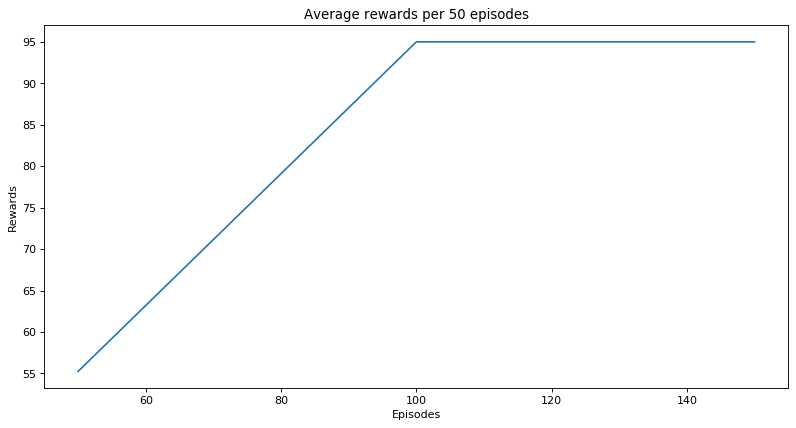

In [11]:
#Plot the average rewards per 50 episodes
plt.figure(figsize=(12,6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Average rewards per 50 episodes')
plt.plot(df['Episodes'], df['Avg_Reward'])

# Calculate Average Rewards per 10 Episodes

In [12]:
sum_rewards = 0
avg_rewards_per_10 = []

for i in range (1, len(episodes_rewards_list)+1):
    sum_rewards += episodes_rewards_list[i-1] 
    if (i%10) == 0 :
        avg_rewards_per_10.append(sum_rewards/10)
        sum_rewards=0
    if (i==len(episodes_rewards_list)):
        if (i%10==0):
            break
        else:
            avg_rewards_per_10.append(sum_rewards/(i%10))
        
avg_rewards_per_10

len(avg_rewards_per_10)

11

In [13]:
df_10 = pd.DataFrame()
df_10 = df_10.fillna(0)
df_10['Avg_Reward'] = avg_rewards_per_10
df_10['Episodes'] = (df_10.index+1)*10


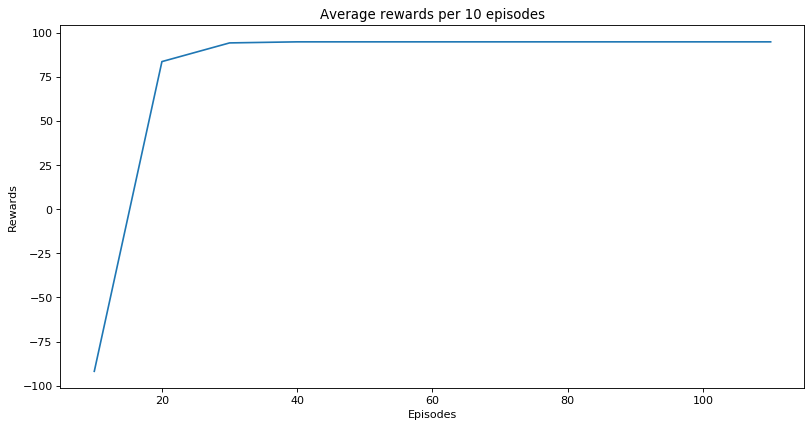

In [14]:
#Plot the average rewards per 10 episodes
plt.figure(figsize=(12,6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Average rewards per 10 episodes')
plt.plot(df_10['Episodes'], df_10['Avg_Reward'])

# Calculate Reward per episode

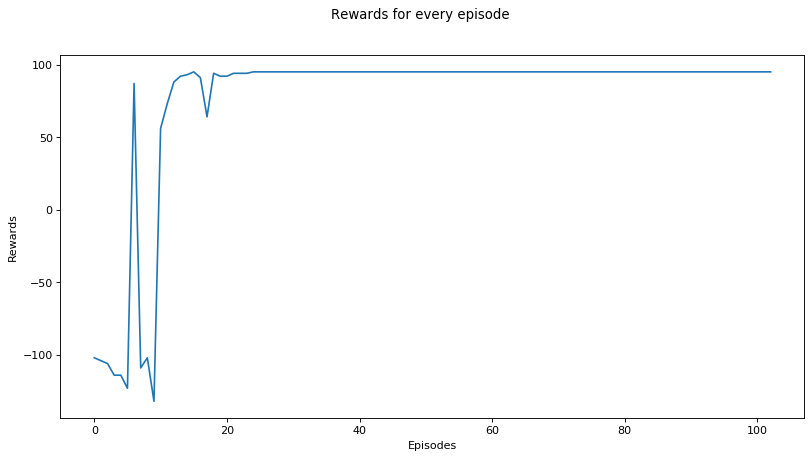

In [15]:
#%% Plot the reward for every episode
reward_per_episode = pd.DataFrame(np.asarray(episodes_rewards_list)) 
reward_per_episode['episodes'] = reward_per_episode.index
reward_per_episode.columns = ['total_reward', 'episodes']


plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.suptitle('Rewards for every episode')
plt.plot(reward_per_episode['episodes'], reward_per_episode['total_reward'])